# Four-momentum tests

In these examples, we get out the information from an ntuple needed to reconstruct the momentum of jets and LLPs.

### Ntuple column names
First, just print out all the TBranch names in the ROOT file, so we can see what we have to work with.

In [1]:
import uproot
input_file = uproot.open('/LLPData/Outputs/CalRatio_ntuples2016dataAnalysis_paperVersion/signal_HSS_LLP_mH125_mS25_lt9m_ntuples2016dataAnalysis_paperVersion.root')
base_awkward_array = input_file[input_file.keys()[0]].lazyarrays(namedecode='utf-8')
for key in base_awkward_array:
    print(key)

eventNumber
eventCount
runNumber
lumiBlock
backgroundFlags
eventWeight
pdfEventWeights
pileupEventWeight
xSecEventWeight
actualIntPerCrossing
averageIntPerCrossing
event_NCleanJets
event_NJets
event_HT
event_MHToHT
event_HTMiss
event_Meff
event_sumMinDR
METCST_met
METTST_met
event_tauRoI_maxET
event_passL1TAU60
event_passL1LLPNOMATCH
event_passEmulationL1LLPNOMATCH
event_passL1LLPRO
event_passCalRatio_cleanLLP_TAU60
event_passCalRatio_cleanLLP_TAU60_noiso
event_passCalRatio_cleanLLP_LLPNOMATCH
event_passCalRatio_cleanLLP_LLPNOMATCH_noiso
event_passEmulationCalRatio_cleanLLP_LLPNOMATCH_noiso
event_passJ320_bperf_split
dPhiLeadBDTsignalWeight_cleanJet
dRLeadBDTsignalWeight_cleanJet
dPhiLeadBDTmultijetsWeight_cleanJet
dRLeadBDTmultijetsWeight_cleanJet
dPhiLeadBDTbibWeight_cleanJet
dRLeadBDTbibWeight_cleanJet
event_BDTtau60
event_BDTllpnm
BDT3weights_signal_cleanJet_index
BDT3weights_multijets_cleanJet_index
BDT3weights_bib_cleanJet_index
CalibJet_isGoodStand
CalibJet_isGoodLLP
CalibJet_E


### Setup
Add the right path, import the right library, and set up the event stream.

In [2]:
import sys
sys.path.append('..')
from clientlib.DataSets import ArrayDataSet

In [3]:
real_awkward_dataset = ArrayDataSet('/LLPData/Outputs/CalRatio_ntuples2016dataAnalysis_paperVersion/signal_HSS_LLP_mH125_mS25_lt9m_ntuples2016dataAnalysis_paperVersion.root')
real_awkward_array_stream = real_awkward_dataset.AsAwkwardArray()

## Query
Here we actually set the query that will run on the ntuple. This will select the energy, pT, eta, and phi of every jet and every LLP.

In [4]:
real_awkward_query = real_awkward_array_stream.Select('lambda e: ((e.CalibJet_E, e.CalibJet_pT, e.CalibJet_eta, e.CalibJet_phi), (e.LLP_E, e.LLP_pT, e.LLP_eta, e.LLP_phi))')

Now run the query, which should take a few seconds.

In [5]:
%time output_array = real_awkward_query.value()

CPU times: user 35.5 ms, sys: 19.1 ms, total: 54.7 ms
Wall time: 7.89 s


## Custom Python implementation of four-vectors
We need to do operations on four-vectors, like adding two together and getting invariant masses. I've written my own version of the necessary objects and operators here. This may be reinventing the wheel a bit, but there are still some issues with using `uproot-methods`'s implementation, so this will have to do for now.

In [6]:
from numpy import arcsinh, arctan2, hypot, isinf, cosh, cos, sin, sinh, sqrt
from math import pi

def get_eta_from_pT_and_pz(pT, pz):
    #if pT != 0:
        return arcsinh(pz / pT)
    #elif pz == 0:
    #    return 0
    #else:
    #    return float('infinity') * pz

class ThreeMomentum:
    def __init__(self, px, py, pz):
        self._px = px
        self._py = py
        self._pz = pz
        
    def __str__(self):
        return ('(' + str(self._px) + ', '
                    + str(self._py) + ', '
                    + str(self._pz) + ')')
    
    def px(self):
        return self._px
    
    def py(self):
        return self._py
    
    def pz(self):
        return self._pz
    
    def pT(self):
        return hypot(self._px, self._py)

    def eta(self):
        return get_eta_from_pT_and_pz(self.pT(), self._pz)
    
    def phi(self):
        return arctan2(self._py, self._px)
        
    def __add__(self, other):
        return ThreeMomentum(self._px + other._px, self._py + other._py, self._pz + other._pz)

def get_smallest_radian_value(angle):
    greater_than_pi = angle > pi
    while greater_than_pi.flatten().sum() if hasattr(greater_than_pi, "flatten") else greater_than_pi:
        greater_than_pi = greater_than_pi * -2 * pi
        angle = angle + greater_than_pi
        greater_than_pi = angle > pi
    less_than_negative_pi = angle < -pi
    while less_than_negative_pi.flatten().sum() if hasattr(less_than_negative_pi, "flatten") else less_than_negative_pi:
        less_than_negative_pi = less_than_negative_pi * 2 * pi
        angle = angle + less_than_negative_pi
        less_than_negative_pi = angle < -pi
    #while angle > pi:
    #    angle -= 2 * pi
    #while angle < -pi:
    #     angle += 2 * pi
    return angle

class FourMomentum:
    def __init__(self, E, pT, eta, phi):
        #if isinf(E) or E < pT or pT < 0:
        #    raise ValueError()
        #if E == 0:
        #    if pT != 0:
        #        raise ValueError()
        #    self._E = E
        #    self._pT = pT
        #    self._eta = float('nan')
        #    self._phi = float('nan')
        #elif pT == 0:
        #    if not isinf(eta):
        #        raise ValueError()
        #    self._E = E
        #    self._pT = pT
        #    self._eta = eta
        #    self._phi = float('nan')
        #else:
        #    if isinf(eta) or isinf(phi):
        #        raise ValueError()
        #    if (pT * cosh(eta)) / E > 1.001:
        #        raise ValueError()
            self._E = E
            self._pT = pT
            self._eta = eta
            self._phi = get_smallest_radian_value(phi)
            
    @classmethod
    def from_E_and_p3(cls, E, p3):
        return cls(E, p3.pT(), p3.eta(), p3.phi())
            
    def __str__(self):
        return (  'E = '   + str(self._E)   + ', '
                + 'pT = '  + str(self._pT)  + ', '
                + 'eta = ' + str(self._eta) + ', '
                + 'phi = ' + str(self._phi))
        
    def E(self):
        return self._E
    
    def pT(self):
        return self._pT
    
    def eta(self):
        return self._eta
    
    def phi(self):
        return self._phi
    
    def px(self):
        #if self._pT == 0:
        #    return 0
        #else:
            return self._pT * cos(self._phi)
    
    def py(self):
        #if self._pT == 0:
        #    return 0
        #else:
            return self._pT * sin(self._phi)
    
    def pz(self):
        #if isinf(self._eta):
        #    raise NotImplementedError('Unable to calculate pz if pT = 0')
        #else:
            return self._pT * sinh(self._eta)
        
    def eta(self):
        return self._eta
    
    def phi(self):
        return self._phi

    def p3(self):
        return ThreeMomentum(self.px(), self.py(), self.pz())
    
    def __add__(self, other):
        new_E = self._E + other._E
        new_p3 = self.p3() + other.p3()
        return self.from_E_and_p3(new_E, new_p3)
        
    def p3_squared(self):
        return self.px() ** 2 + self.py() ** 2 + self.pz() ** 2
        
    def p3_magnitude(self):
        return sqrt(self.p3_squared())
    
    def m(self):
        return sqrt(self._E ** 2 - self.p3_squared())
    
    def __getitem__(self, key):
        return FourMomentum(self.E()[key], self.pT()[key], self.eta()[key], self.phi()[key])
        
def deltaEta(v1, v2):
    return v2.eta() - v1.eta()

def deltaPhi(v1, v2):
    return get_smallest_radian_value(v2.phi() - v1.phi())

def deltaR(v1, v2):
    return hypot(deltaEta(v1, v2), deltaPhi(v1, v2))

## Construct four-vectors for jets and LLPs
Next, just pick out the right columns and make the FourMomentum objects. The above implementation is intentionally agnostic to whether the inputs are scalars or arrays of arbitrary dimensions. As long as the inputs match in shape, you'll get all the four-vectors out in a form that matches the inputs. I make one array for jets and one array for LLPs.

In [7]:
jet_E = output_array[0][0]
jet_pT = output_array[0][1]
jet_eta = output_array[0][2]
jet_phi = output_array[0][3]
jet_p4 = FourMomentum(jet_E, jet_pT, jet_eta, jet_phi)

In [8]:
LLP_E = output_array[1][0]
LLP_pT = output_array[1][1]
LLP_eta = output_array[1][2]
LLP_phi = output_array[1][3]
LLP_p4 = FourMomentum(LLP_E, LLP_pT, LLP_eta, LLP_phi)

## Plots
Use the FourMomentum arrays to plot the jet and LLP parameters.

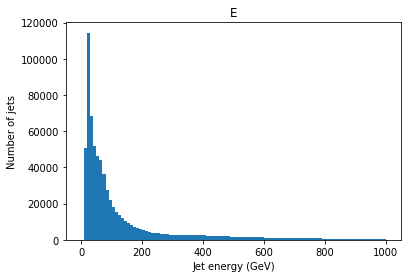

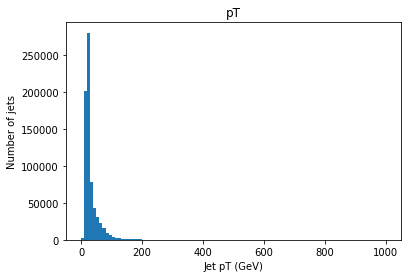

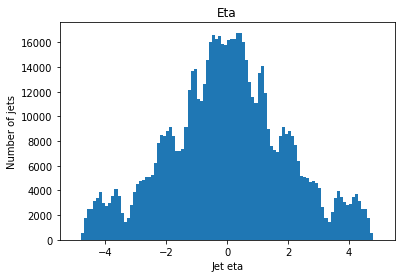

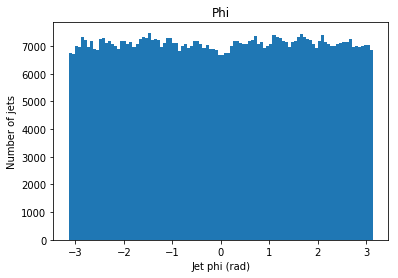

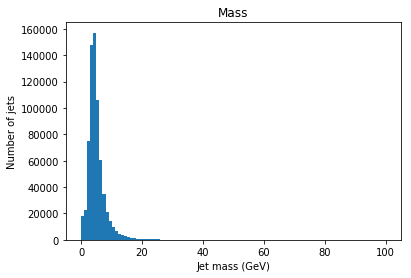

In [14]:
import matplotlib.pyplot as plt

plt.hist(jet_p4.E().flatten(), 100, (0,1000))
plt.title('E')
plt.xlabel('Jet energy (GeV)')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.pT().flatten(), 100, (0,1000))
plt.title('pT')
plt.xlabel('Jet pT (GeV)')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.eta().flatten(), 100, (-5,5))
plt.title('Eta')
plt.xlabel('Jet eta')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.phi().flatten(), 100, (-pi,pi))
plt.title('Phi')
plt.xlabel('Jet phi (rad)')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.m().flatten(), 100, (0,100))
plt.title('Mass')
plt.xlabel('Jet mass (GeV)')
plt.ylabel('Number of jets')
plt.show()

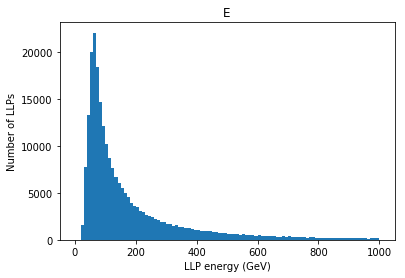

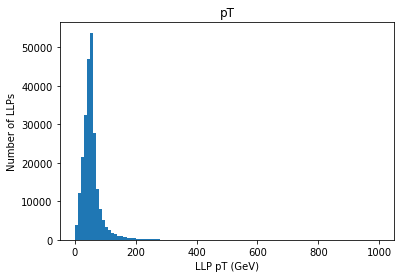

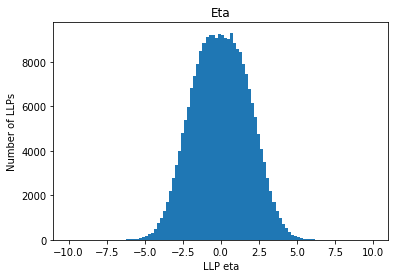

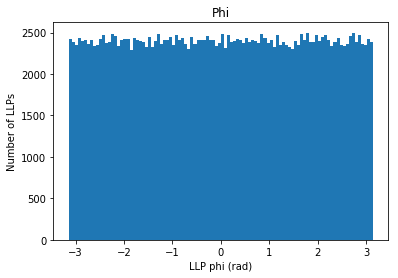

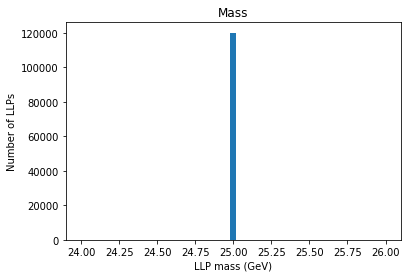

In [10]:
plt.hist(LLP_p4.E().flatten() / 1000, 100, (0,1000))
plt.title('E')
plt.xlabel('LLP energy (GeV)')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.pT().flatten() / 1000, 100, (0,1000))
plt.title('pT')
plt.xlabel('LLP pT (GeV)')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.eta().flatten(), 100, (-10,10))
plt.title('Eta')
plt.xlabel('LLP eta')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.phi().flatten(), 100, (-pi,pi))
plt.title('Phi')
plt.xlabel('LLP phi (rad)')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.m().flatten() / 1000, 100, (24,26))
plt.title('Mass')
plt.xlabel('LLP mass (GeV)')
plt.ylabel('Number of LLPs')
plt.show()

## Four-vector sums
We can verify the four-vector addition by summing the two LLPs in each event and ploting the resulting kinematics. This should correspond to the phi scalar mediator with a mass of 125 GeV.

In [11]:
LLP_p4_sums = LLP_p4[:,0] + LLP_p4[:,1]

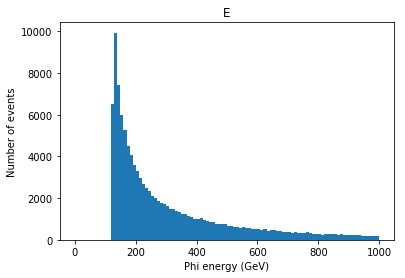

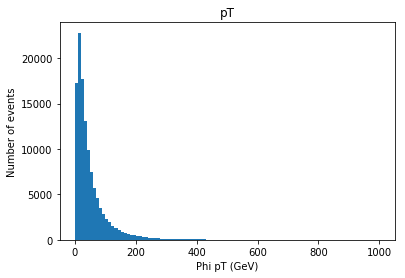

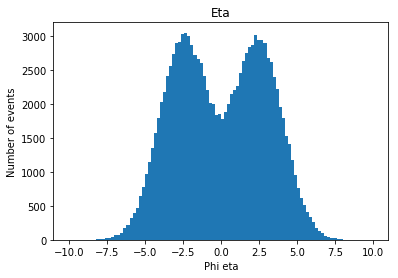

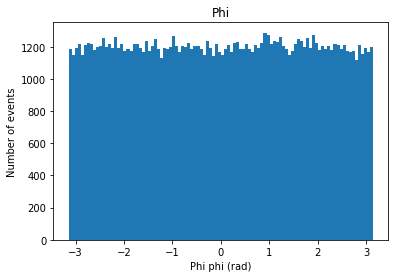

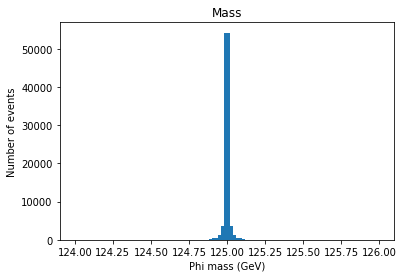

In [12]:
plt.hist(LLP_p4_sums.E() / 1000, 100, (0,1000))
plt.title('E')
plt.xlabel('Phi energy (GeV)')
plt.ylabel('Number of events')
plt.show()

plt.hist(LLP_p4_sums.pT() / 1000, 100, (0,1000))
plt.title('pT')
plt.xlabel('Phi pT (GeV)')
plt.ylabel('Number of events')
plt.show()

plt.hist(LLP_p4_sums.eta(), 100, (-10,10))
plt.title('Eta')
plt.xlabel('Phi eta')
plt.ylabel('Number of events')
plt.show()

plt.hist(LLP_p4_sums.phi(), 100, (-pi,pi))
plt.title('Phi')
plt.xlabel('Phi phi (rad)')
plt.ylabel('Number of events')
plt.show()

plt.hist(LLP_p4_sums.m() / 1000, 100, (124,126))
plt.title('Mass')
plt.xlabel('Phi mass (GeV)')
plt.ylabel('Number of events')
plt.show()

## LLP-jet matching
Finally, quickly check the `deltaR()` method. Let's look at all the jets in the first event and see if any can be matched to the LLPs.

In [13]:
for event_jet_p4, event_llp_p4 in zip(jet_p4, LLP_p4):
    print('jets:')
    for indiv_jet_p4 in event_jet_p4:
        print(indiv_jet_p4)
    print('LLPs:')
    for indiv_llp_p4 in event_llp_p4:
        print(indiv_llp_p4)
    llp_num = 0
    for indiv_llp_p4 in event_llp_p4:
        llp_num += 1
        print('LLP ' + str(llp_num) + ':')
        jet_num = 0
        for indiv_jet_p4 in event_jet_p4:
            jet_num += 1
            print('\tjet', jet_num, 'deltaR:', deltaR(indiv_llp_p4, indiv_jet_p4))
    break

jets:
E = 209.45963567695793, pT = 85.585328125, eta = -1.5411477088928223, phi = 1.5399823188781738
E = 50.8569008621466, pT = 30.156796875, eta = 1.1030752658843994, phi = -1.7798477411270142
E = 38.23670360942477, pT = 27.329365234375, eta = -0.8471185564994812, phi = 1.7790178060531616
E = 23.43329205292181, pT = 22.639572265625, eta = -0.12941420078277588, phi = 0.2987922728061676
E = 34.08531686173584, pT = 21.113765625, eta = 1.0522892475128174, phi = 2.3908755779266357
E = 21.40224822199898, pT = 19.114765625, eta = -0.43428581953048706, phi = 1.3274266719818115
E = 18.774834928534673, pT = 17.340818359375, eta = -0.35882750153541565, phi = -2.048685312271118
E = 17.40520495450177, pT = 16.1868828125, eta = 0.33463695645332336, phi = -1.041507601737976
LLPs:
E = 166898.46875, pT = 65596.34050706915, eta = -1.5735909965496448, phi = 1.5547155588639499
E = 326920.8125, pT = 27499.00248973422, eta = -3.1639988776541808, phi = -1.5469162668364922
LLP 1:
	jet 1 deltaR: 0.03563194177

Clearly the first jet matches the first LLP. It looks like the second LLP is a bit too far out in eta, and no jet matches.